This notebook aims to benchmark wich Julia solver in the most efficient, compared to already implemented OGGM's schemes

In [24]:
# %%
import time
import timeit

import oggm
from oggm import cfg, utils, workflow, tasks, graphics, global_tasks
from oggm.core import flowline, massbalance
import salem
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import functools
from oggm.shop import gcm_climate

cfg.initialize(logging_level='WARNING')

cfg.PARAMS['use_multiprocessing']=False
cfg.PATHS['working_dir'] = '/home/gimenelu/Run_oggm/'
cfg.PARAMS['continue_on_error'] = True

cfg.PARAMS['use_inversion_params_for_run']= True
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5/'

2023-07-26 15:18:29: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-07-26 15:18:29: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-07-26 15:18:29: oggm.cfg: Multiprocessing: using all available processors (N=16)
2023-07-26 15:18:29: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


In [25]:
from juliacall import Main as jl
jl.seval("using Revise")
jl.seval("using Distributed")
jl.seval("using ProgressMeter")
jl.seval("using OrdinaryDiffEq")
jl.seval("using Random")
jl.seval("using SugarBLAS")
jl.seval("using Statistics")
jl.seval("using BenchmarkTools")
jl.seval("using JLD2")
jl.seval("using DataFrames")
jl.seval("using Plots")
jl.seval("using StatsPlots")
jl.seval("using Logging: global_logger")
jl.seval("using TerminalLoggers: TerminalLogger")
jl.seval("using CategoricalArrays")

In [45]:
rgi_ids=["RGI60-11.03638","RGI60-11.03671","RGI60-11.03643","RGI60-11.03674","RGI60-11.03756", #Argentière, Gébroulaz, Mer de Glace,St-Sorlin, Sarennes
    "RGI60-16.00543","RGI60-16.01339", #Zongo, Antizana
    "RGI60-11.03232", #Ossoue
    "RGI60-15.03591", #Mera
    "RGI60-11.03646",
    "RGI60-14.07524", #Siachen
    "RGI60-01.05355"] #Alexander (Alaska)*

ude_solvers = [jl.BS3(),jl.OwrenZen3(),jl.RDPK3Sp35(),jl. ROCK4(), 
               jl.Ralston(),jl.VCABM5(),jl.Vern6()]

#FBDF & QNDF trop long

samples = 10
ny = 500
def BenchmarkingAll(rgi_list,solver_list): #to benchmark all the glaciers from the list on different solvers

    reltol = 1e-5
    
    n = len(rgi_list)
    ude_benchmark = {"id":[], "ude_settings":[], "SemiImp_stats":[], "FluxBased_stats":[]}
    

    
    for r in rgi_list:
        #Initialize glacier
        rgi = [r]
        gdirs=gdirs = workflow.init_glacier_directories(rgi, from_prepro_level=3, prepro_base_url=base_url, prepro_border=80)
        gdir=gdirs[0]
        tasks.init_present_time_glacier(gdir)
        
        ude_benchmark["id"].append(r)
        
        
        #Benchmarking OGGM schemes 
        cfg.PARAMS["evolution_model"] = "SemiImplicit"

        tico = time.perf_counter()
        for t in range(0,samples): 
            workflow.execute_entity_task(tasks.run_random_climate, gdir, y0 = 2003, nyears=ny,seed=1,store_fl_diagnostics=True,store_model_geometry=True)
        toco = time.perf_counter()

        t_stats_o = (toco-tico)/samples
        ude_benchmark["SemiImp_stats"].append(t_stats_o)  


        cfg.PARAMS["evolution_model"] = "FluxBased"

        tico2 = time.perf_counter()
        for t in range(0,samples):
            workflow.execute_entity_task(tasks.run_random_climate, gdir, y0 = 2003, nyears=ny,seed=1,store_fl_diagnostics=True,store_model_geometry=True)
        toco2 = time.perf_counter()

        t_stats_o2 = (toco2-tico2)/samples
        ude_benchmark["FluxBased_stats"].append(t_stats_o2)  
        
        cfg.PARAMS["evolution_model"] = "SIA_1D"
        ude_settings={"solver":[],"time_stats":[]}
        
        for s in solver_list:

            cfg.PARAMS["Julia_solver"] = s

            ude_settings["solver"].append(s)
            ticj = time.perf_counter()
            for t in range(0,samples):
                workflow.execute_entity_task(tasks.run_random_climate, gdir, y0 = 2003, nyears=ny,seed=1,store_fl_diagnostics=True,store_model_geometry=True)
            tocj = time.perf_counter()

            # Save stats for each solver
            t_stats = (tocj - ticj)/samples
            ude_settings["time_stats"].append(t_stats)
        
        ude_benchmark["ude_settings"].append(ude_settings)

    return ude_benchmark



In [46]:
test=BenchmarkingAll(rgi_ids,ude_solvers)

2023-07-26 16:15:04: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2023-07-26 16:15:04: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2023-07-26 16:15:04: oggm.cfg: PARAMS['evolution_model'] changed from `SIA_1D` to `SemiImplicit`.
2023-07-26 16:15:04: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:15:05: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:15:06: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:15:07: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:15:08: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:15:09: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:15:10: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:15:11: oggm.workflow: Execute entity tasks [run_random_cli

2023-07-26 16:16:09: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:16:09: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:16:10: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:16:11: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:16:12: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:16:12: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:16:13: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:16:14: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:16:15: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:16:15: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:16:16: oggm.cfg: PARAMS['Julia_solver'] changed from `VCABM5()` to

2023-07-26 16:17:06: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:17:06: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:17:07: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:17:08: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:17:09: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:17:09: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:17:10: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:17:10: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:17:11: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:17:12: oggm.cfg: PARAMS['Julia_solver'] changed from `ROCK4{Nothing}(0, 152, nothing)` to `Ralston(stage_limiter! = trivial_limiter!, step_limiter! = trivial_

2023-07-26 16:18:37: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:18:38: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:18:38: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:18:39: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:18:40: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:18:41: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:18:41: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:18:42: oggm.cfg: PARAMS['Julia_solver'] changed from `OwrenZen3(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))` to `RDPK3Sp35(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))`.
2023-07-26 16:18:42: oggm.workflow: Execute entity tasks [run_random_climat

2023-07-26 16:19:49: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:19:50: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:19:51: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:19:52: oggm.cfg: PARAMS['evolution_model'] changed from `FluxBased` to `SIA_1D`.
2023-07-26 16:19:52: oggm.cfg: PARAMS['Julia_solver'] changed from `Vern6(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false), lazy = true)` to `BS3(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))`.
2023-07-26 16:19:52: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:19:52: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:19:53: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:19:53: oggm.workflow: Execute entity tasks [run_random_

2023-07-26 16:20:29: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:20:29: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:20:30: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2023-07-26 16:20:30: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2023-07-26 16:20:30: oggm.cfg: PARAMS['evolution_model'] changed from `SIA_1D` to `SemiImplicit`.
2023-07-26 16:20:30: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:20:31: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:20:32: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:20:32: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:20:33: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:20:34: oggm.workflow: Execute entity tasks [run_random_cli

2023-07-26 16:21:19: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:21:19: oggm.cfg: PARAMS['Julia_solver'] changed from `Ralston(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))` to `VCABM5()`.
2023-07-26 16:21:19: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:21:20: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:21:20: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:21:20: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:21:21: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:21:21: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:21:22: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:21:23: oggm.workflow: Execute entity tasks [run_random_climate] o

2023-07-26 16:22:21: oggm.cfg: PARAMS['Julia_solver'] changed from `RDPK3Sp35(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))` to `ROCK4{Nothing}(0, 152, nothing)`.
2023-07-26 16:22:21: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:22:22: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:22:22: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:22:23: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:22:24: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:22:24: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:22:25: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:22:25: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:22:26: oggm.workflow: Execute entity tas

2023-07-26 16:23:49: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:23:50: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:23:51: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:23:52: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:23:53: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:23:53: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:23:54: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:23:55: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:23:55: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:23:56: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:23:57: oggm.cfg: PARAMS['Julia_solver'] changed from `OwrenZen3(st

2023-07-26 16:24:59: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:25:00: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:25:01: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:25:02: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:25:03: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:25:04: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:25:05: oggm.cfg: PARAMS['evolution_model'] changed from `FluxBased` to `SIA_1D`.
2023-07-26 16:25:05: oggm.cfg: PARAMS['Julia_solver'] changed from `Vern6(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false), lazy = true)` to `BS3(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))`.
2023-07-26 16:25:05: oggm.workflow: Execute entity tasks [run_random_

2023-07-26 16:25:50: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:25:50: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:25:51: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:25:51: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:25:52: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:25:53: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2023-07-26 16:25:53: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2023-07-26 16:25:53: oggm.cfg: PARAMS['evolution_model'] changed from `SIA_1D` to `SemiImplicit`.
2023-07-26 16:25:53: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:25:54: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:25:55: oggm.workflow: Execute entity tasks [run_random_cli

2023-07-26 16:27:01: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:27:02: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:27:03: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:27:04: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:27:05: oggm.cfg: PARAMS['Julia_solver'] changed from `Ralston(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))` to `VCABM5()`.
2023-07-26 16:27:05: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:27:06: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:27:06: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:27:07: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:27:08: oggm.workflow: Execute entity tasks [run_random_climate] o

2023-07-26 16:28:55: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:28:56: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:28:57: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:28:57: oggm.cfg: PARAMS['Julia_solver'] changed from `RDPK3Sp35(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))` to `ROCK4{Nothing}(0, 152, nothing)`.
2023-07-26 16:28:57: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:28:58: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:28:59: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:29:00: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:29:01: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:29:02: oggm.workflow: Execute entity tas

2023-07-26 16:31:30: oggm.cfg: PARAMS['Julia_solver'] changed from `BS3(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))` to `OwrenZen3(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))`.
2023-07-26 16:31:30: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:31:31: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:31:32: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:31:34: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:31:35: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:31:37: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:31:38: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:31:39: oggm.workflow: Execute entity tasks [run_random_climate] on 

2023-07-26 16:33:10: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:33:11: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:33:12: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:33:13: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:33:14: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:33:15: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:33:16: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:33:17: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:33:19: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:33:20: oggm.cfg: PARAMS['evolution_model'] changed from `FluxBased` to `SIA_1D`.
2023-07-26 16:33:20: oggm.cfg: PARAMS['Julia_solver'] changed from `Vern6(sta

2023-07-26 16:33:58: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:33:58: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:33:59: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:34:00: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:34:01: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:34:01: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:34:02: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-07-26 16:34:02: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers


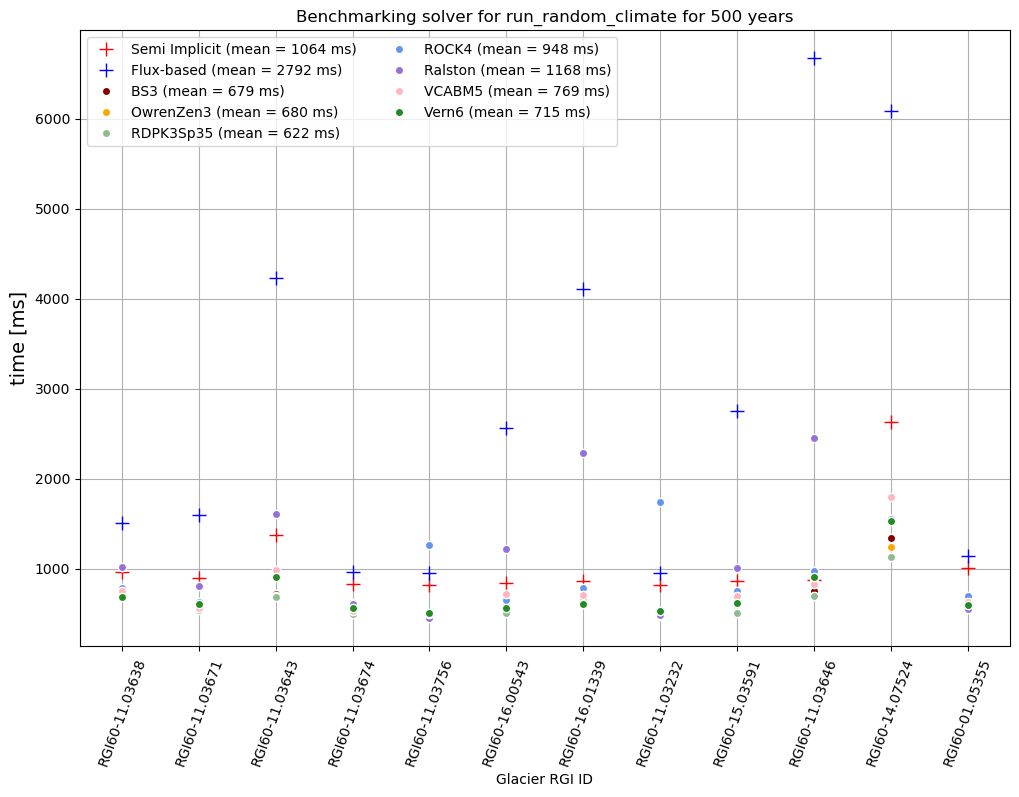

In [47]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches


f= plt.subplots(figsize=(12, 8))
handles, labels = plt.gca().get_legend_handles_labels()  

ude_solvers_str=["BS3","OwrenZen3","RDPK3Sp35","ROCK4","Ralston","VCABM5","Vern6"]


ng=len(rgi_ids)
ns= len(ude_solvers_str)

mean_si = round(np.mean(test["SemiImp_stats"])*1e3)
mean_fb = round(np.mean(test["FluxBased_stats"])*1e3)
mean_s =np.array([0]*ns)

plt.plot(test["id"],np.array(test["SemiImp_stats"])*1e3,marker='+',color='r',markersize = 10,linestyle='none')

plt.plot(test["id"],np.array(test["FluxBased_stats"])*1e3,marker='+',color='b',markersize = 10,linestyle='none')


plt.xticks(rotation = 70)
plt.ylabel('time [ms]', fontsize = 14)
plt.xlabel('Glacier RGI ID')
colors=["maroon","orange","darkseagreen","cornflowerblue","mediumpurple","lightpink","forestgreen"]

point = Line2D([0], [0], label='Semi Implicit (mean = {} ms)'.format(mean_si), marker='+', markersize=10, 
         markeredgecolor='r', markerfacecolor='r', linestyle='')

point2 = Line2D([0], [0], label='Flux-based (mean = {} ms)'.format(mean_fb), marker='+', markersize=10, 
         markeredgecolor='b', markerfacecolor='b', linestyle='')


for i in range(0,ng):
    for j in range(0,ns):
    
        plt.plot(rgi_ids[i],test["ude_settings"][i]["time_stats"][j]*1e3, marker='o', markersize=6,
             markeredgecolor='w',markerfacecolor=colors[j])
        mean_s[j] += test["ude_settings"][i]["time_stats"][j]*1e3

mean_s = mean_s/ng
handles = [point,point2]
for k in range(0,ns):
    p = Line2D([0], [0], label=ude_solvers_str[k]+' (mean = {} ms)'.format(round(mean_s[k])), marker='o', markersize=6, 
         markeredgecolor='w', markerfacecolor=colors[k], linestyle='')
    handles.append(p)


plt.legend(handles=handles,fontsize=10,loc=2,ncols=2)
#for k in range(0,ng):
#for j in range(0,ns):
        
plt.title('Benchmarking solver for run_random_climate for 500 years')
plt.grid()